# Mobility data analysis
Notebook inspired from Open humans project https://www.openhumans.org

Read mobility files from Open humans
https://www.openhumans.org/api/public-data/?source=direct-sharing-138

Author: Liubov
Thanks to Bastian for inspiration from their notebooks 
https://exploratory.openhumans.org/notebooks/?source=Moves%20connection


In [1]:
import sys
!{sys.executable} -m pip install folium

import folium

import json
from pprint import pprint


'''
Functions:
 to estimate the distribution of stop duration
 to estimate the distribution of jump length
'''

def duration_stop_distribution(daily_segments):
    """
    takes a daily segment of Moves 
    returns sorted distribution of stops duration
        Can be misleading for days w/ lots of travel etc. 
    """
    places_of_day = []
    duration_seq = [] #sequence of durations of stops
    for i in daily_segments:
        if i['type'] == 'place':
            place_location = i['place']['location']
            start_time = datetime.strptime(i['startTime'],'%Y%m%dT%H%M%S%z')
            end_time = datetime.strptime(i['endTime'],'%Y%m%dT%H%M%S%z')
            duration = end_time - start_time
            duration_seq.append([duration])
    duration_seq.sort() 
    return duration_seq 

def len_jumps_distribution(daily_segments):
    """
    takes a daily segment of Moves 
    returns the distribution of jumps lengths (calculated from lat/long of stops)
    can be misleading for days w/ lots of travel etc. 
    """
    places_of_traj = [] #returns array of all locations during the day
    for i in daily_segments: 
        if i['type'] == 'place':
            place_location = i['place']['location']
            places_of_traj.append([place_location])
    return places_of_traj


def longest_daily_location(daily_segments):
    """
    Function from Bastian (Open Humans)
    
    takes a daily segment log of Moves and returns the 
    lat/long for the location where most time was spent. 
    Can be misleading for days w/ lots of travel etc. 
    But the most quick/dirty solution for now.
    """
    places_of_day = []
    for i in daily_segments:
        if i['type'] == 'place':
            place_location = i['place']['location']
            start_time = datetime.strptime(i['startTime'],'%Y%m%dT%H%M%S%z')
            end_time = datetime.strptime(i['endTime'],'%Y%m%dT%H%M%S%z')
            duration = end_time - start_time
            places_of_day.append([place_location,duration])
    places_of_day.sort(key=lambda tup: tup[-1],reverse=True)
    return places_of_day[0][0]






You are using pip version 9.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.



# data example
Example of data 
Read mobility files from Open humans

https://www.openhumans.org/api/public-data/?source=direct-sharing-138
  

[{'caloriesIdle': 1679,
  'date': '20130515',
  'lastUpdate': '20151001T012320Z',
  'segments': [{'activities': [{'activity': 'walking',
                                'calories': 3,
                                'distance': 48.0,
                                'duration': 50.0,
                                'endTime': '20130515T131851-0700',
                                'group': 'walking',
                                'manual': False,
                                'startTime': '20130515T131801-0700',
                                'steps': 96,
                                'trackPoints': []}],
                'endTime': '20130515T132742-0700',
                'lastUpdate': '20151001T012320Z',
                'place': {'id': 61807543,
                          'location': {'lat': 33.99882, 'lon': -118.43657},
                          'name': 'Ramuilar HQ',
                          'type': 'home'},
                'startTime': '20130515T131401-0700',
                'type': 'place'},
               {'activities': [{'activity': 'transport',
                                'distance': 3503.0,
                                'duration': 534.0,
                                'endTime': '20130515T133636-0700',
                                'group': 'transport',
                                'manual': False,
                                'startTime': '20130515T132742-0700',
                                'trackPoints': []}],
                'endTime': '20130515T133637-0700',
                'lastUpdate': '20130515T213146Z',
                'startTime': '20130515T132742-0700',
                'type': 'move'},
               {'activities': [{'activity': 'walking',
                                'calories': 5,
                                'distance': 92.0,
                                'duration': 90.0,
                                'endTime': '20130515T134039-0700',
                                'group': 'walking',
                                'manual': False,
                                'startTime': '20130515T133909-0700',
                                'steps': 184,
                                'trackPoints': []}],
                'endTime': '20130515T142848-0700',
                'lastUpdate': '20140301T070136Z',
                'place': {'foursquareCategoryIds': ['4bf58dd8d48988d14e941735'],
                          'foursquareId': '4a6bdc59f964a52020d01fe3',
                          'id': 61855165,
                          'location': {'lat': 33.99050413968406,
                                       'lon': -118.4649780392647},
                          'name': 'Gjelina',
                          'type': 'foursquare'},

## Main questions about the mobility dataset
Primarily we are interested in two spatial and temporal properties: 
1. distribution of length of stops of human trajectories 
2. distribution of length of jumps between two stops 

With these properties we want to see if different people have different distributions of duration of stops and lengths of stops.


In [2]:
# Get files
import requests
import json
import os 

public_files = requests.get('https://www.openhumans.org/api/public-data/?source=direct-sharing-138').json()

public_data = {}

for i in public_files['results']:
    data = requests.get(i['download_url']).json()
    public_data[i['user']['username']] = data

In [3]:
# Get the members own data if there is any
from ohapi import api

my_data = None
my_files = api.exchange_oauth2_member(os.getenv('OH_ACCESS_TOKEN'))
for i in my_files['data']:
    if i['source'] == 'direct-sharing-138':
        my_data = requests.get(i['download_url']).json()

In [4]:
# main function analyzing moves_data    

from datetime import datetime
from collections import defaultdict
import pandas as pd
import numpy as np
import seaborn as sns


# sets the axis label sizes for seaborn
rc={'font.size': 14, 'axes.labelsize': 14, 'legend.fontsize': 14.0, 
    'axes.titlesize': 14, 'xtick.labelsize': 14, 'ytick.labelsize': 14}
sns.set(rc=rc)


#for printing this huge file of trajectories:    
#pprint(data)
    

'''
function to create new dataframe from the json trajectory file
code adapted from openhumans notebook
'''

def dataframe_from_json(moves_data):
    moves_processed_data = defaultdict(list) #empty dict for processed dataframe
    for datapoint in moves_data:
        # we need to have observed segments for that day. If moves wasn't running we ignore the day
        if datapoint['segments'] != None:
            # did we stay in a place that day and did we walk that day?
            has_places = False
            walked = False
            for i in datapoint['segments']:
                if i['type'] == 'place':
                        # yes, we were in one place w/o moving around too much, we can keep this day
                        has_places = True
                        
            # is this day in our date range of interest and has data?
            if datapoint['summary'] != None and has_places:
                moves_processed_data['date'].append(datapoint['date'])
                for activity in datapoint['summary']:
                    if activity['activity'] == 'walking':
                        moves_processed_data['steps'].append(activity['steps'])
                        moves_processed_data['distance'].append(activity['distance'])
                        walked = True
                        
                # in case of not walking, step count is zero
                if not walked:
                    moves_processed_data['steps'].append(0)
                    moves_processed_data['distance'].append(0)  
                    
                # distribution of stops lengths
                stops_distrib = duration_stop_distribution(datapoint['segments'])
                moves_processed_data['duration'].append(stops_distrib)
                location = longest_daily_location(datapoint['segments'])
                moves_processed_data['lat'].append(location['lat'])
                moves_processed_data['lon'].append(location['lon'])    
    
    
    
    #Now that we have all of the data we can convert it into a single pandas dataframe for easier processing and visualization
    
    moves_dataframe = pd.DataFrame(data={
        'date': moves_processed_data['date'],
        'steps': moves_processed_data['steps'],
        'distance': moves_processed_data['distance'],
        'latitude': moves_processed_data['lat'],
        'longitude': moves_processed_data['lon']
    })   
    
    return moves_dataframe

public_dfs = {}
for k,v in public_data.items():
    print(v[0]['summary'])
    print('---')
    public_dfs[k] = dataframe_from_json(v)
    print(public_dfs[k].head(1))
    print("####")

# check whether member has personal data as well

if my_data: 
    my_df = dataframe_from_json(my_data)

#Now we plot distribution of moves from new dataframe 
# We compare moves from 1st trajectory and 2nd trajectory

for k,v in public_dfs.items():
    sns.distplot(v['distance'])
    
# check whether member has personal data as well
if my_data:
    sns.distplot(my_df['distance'])
# sns.distplot(stops_distrib)



[{'activity': 'walking', 'group': 'walking', 'duration': 3331.0, 'distance': 3458.0, 'steps': 5070, 'calories': 202}, {'activity': 'transport', 'group': 'transport', 'duration': 2383.0, 'distance': 10577.0}]
---
       date  steps  distance  latitude  longitude
0  20130515   5070    3458.0  33.99882 -118.43657
####
None
---
       date  steps  distance   latitude  longitude
0  20160621    511     370.0  35.293041  139.67203
####
[{'group': 'walking', 'calories': 125, 'steps': 2840, 'distance': 2000.0, 'activity': 'walking', 'duration': 2027.0}, {'group': 'transport', 'duration': 6591.0, 'distance': 48880.0, 'activity': 'transport'}]
---
       date  steps  distance  latitude  longitude
0  20140401   2840    2000.0  42.42347  -71.18083
####
None
---
       date  steps  distance   latitude  longitude
0  20160311   4792    3188.0  35.769257  -78.74505
####
[{'distance': 3332.0, 'steps': 4824, 'activity': 'walking', 'calories': 182, 'duration': 3297.0, 'group': 'walking'}, {'group': 'trans

/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:215: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


In [5]:
'''
We plot location of the most popular places from trajectories.
Input:
latitude and longitude from dataframe moves_dataframe
  moves_dataframe = pd.DataFrame(data={
        'date': moves_processed_data['date'],
        'steps': moves_processed_data['steps'],
        'distance': moves_processed_data['distance'],
        'latitude': moves_processed_data['lat'],
        'longitude': moves_processed_data['lon']
    }) 

Output:
Folium map with datapoints
'''



#first we get trajectory datapoints from the file
my_latitude = my_df.latitude.values
my_longitude = my_df.longitude.values

#then we zip two arrays of lat, lon of datapoints
my_latlon = list(zip(my_latitude, my_longitude))
#print(latlon)

#We put map to show first location of New York 40.7808 et la longitude de la ville de New York City est -73.9772.

mapit = folium.Map( location=[40.7808 , -73.9772], zoom_start=6 )

colors = ['blue', 'green', 'yellow', 'orange', 'black', 'grey', 'pink']

#draw connecting line between locations written in latlon file

# check whether member has personal data as well

if my_data: 
    SAF=folium.PolyLine(locations=my_latlon,weight=1,color = 'red')
    mapit.add_child(SAF)
    
# add the public data sets 
lats = {}
longs = {}
latlongs = {}
SAFs = {}

for i, pd in enumerate(public_dfs):
    lats[pd] = public_dfs[pd].latitude.values
    longs[pd] = public_dfs[pd].longitude.values
    latlongs[pd] = list(zip(lats[pd], longs[pd]))
    SAFs[pd]=folium.PolyLine(locations=latlongs[pd],weight=1,color = colors[i])
    mapit.add_child(SAFs[pd])
mapit

### Observations

By looking at the variation of latitude and longitude coordinates we can see bimodality of trajectories, 
which correspond, most probably to "home" <-> "work". 
We will explore this below using CTRW models.

Bastian did analysis of most popular location data in his notebook for Open humans

https://exploratory.openhumans.org/notebooks/?source=Moves%20connection


#  Continuous time random walk analysis of trajectories
### Definition
*Continuous time random walk* (CTRW) is a generalization of a random walk where the wandering particle waits for a random time between jumps. 
It is a stochastic jump process with arbitrary distributions of jump lengths and waiting times.
More generally it can be seen to be a special case of a Markov renewal process. 

Important properties of CTRW are r(t) and d(t) distributions of lengths of jumps and durations correspondingly. 

For more details look at code and papers here 
https://github.com/Liyubov/networks_random_walking

### Analysis 

We use here several methods of analysis of trajectories using CTRW framework. 

1. Standard deviation. 
Given the input trajectory r(t) =(x(t),y(t)), we first estimate standard deviation for trajectory (STD), which is just the root of variance so var(τ)=(Var(r(t)-r(t-τ))), calculating it in Euclidean space.


2. 
One can also estimate Hurst exponent, which is used as a measure of long-term memory of time series
https://en.wikipedia.org/wiki/Hurst_exponent#Estimating_the_exponent.
Hurst exponent relates to the autocorrelations of the time series, and the rate at which these decrease as the lag between pairs of values increases. 
For any trajectory we can write Var(τ) ∝ τ^(2H), where H is the Hurst exponent.
Hence (Var(z(t)-z(t-τ))) ∝ τ^(2H). 
Then 
[log (Var(z(t)-z(t-τ))) / log τ ] / 2 ∝ H (gives the Hurst exponent) where we know the term in square brackets on far left is the slope of a log-log plot of tau and a corresponding set of variances.
*Range of Hurst exponent.*
A value H in the range 0.5–1 indicates a time series with long-term positive autocorrelation, meaning both that a high value in the series will probably be followed by another high value and that the values a long time into the future will also tend to be high. A value in the range 0 – 0.5 indicates a time series with long-term switching between high and low values in adjacent pairs, meaning that a single high value will probably be followed by a low value and that the value after that will tend to be high, with this tendency to switch between high and low values lasting a long time into the future. A value of H=0.5 can indicate a completely uncorrelated series.


In [13]:

'''
We adapt the function to estimate:
1.  STD of trajectories;
2.  Hurst exponent for trajectories.

First we estimate STD 
Then we estimate Hurst exponent. 

'''

print("Calculating STD of first trajectory ")  

#load trajectory in 2D 
data1 = np.asarray(latlon1)
print("std of trajectory : ", np.std(data1)) 


lags = range(2,100)
def hurst_exponen_chan(p):
    '''
    given series p(t), where t is time 
    '''    
    variancetau = []; tau = []

    for lag in lags: 

        #  Write the different lags into a vector to compute a set of tau or lags
        tau.append(lag)

        # Compute the log returns on all days, then compute the variance on the difference in log returns
        # call this pp or the price difference
        pp = np.subtract(p[lag:], p[:-lag])
        variancetau.append(np.var(pp))

    # we now have a set of tau or lags and a corresponding set of variances.
    #print tau
    #print variancetau

    # plot the log of those variance against the log of tau and get the slope
    m = np.polyfit(np.log10(tau),np.log10(variancetau),1)

    hurst = m[0] / 2

    return hurst

print('hurtst exponent')
print(hurst_exponen_chan(data1))


Calculating STD of first trajectory 
std of trajectory :  75.8244193362
hurtst exponent
0.0316731771675


### Estimation of scaling exponent of trajectory 

Given trajectory displacements r(t) = t^(-b-1),  we estimate b constant from the trajectory. 
Then  we fit this distribution of travelling distances to a power law. 

If parameter b<2, then this indicates that trajectories are reminiscent of scale-free random walks known as Le´vy flights. If parameter b>2, this indicates that trajectory generating process is related to normal spreading.

For this we are using Python package for  analysis of diffusion data
https://diffusion-analysis-md-simulations.readthedocs.io/en/latest/diffusion_analysis.html

    *diffusion_analysis.fit_anomalous_diffusion_data(time_data_array, MSD_data_array, degrees_of_freedom=2)*
    
function should fit anomalous diffusion data to Equation 1 in [Kneller2011], and return appropriate diffusion parameters:    MSD=ND_αt^α.


In [19]:
'''
We adapt the function to estimate:
1.  STD of trajectories;
2.  beta exponent 
'''

import numpy as np 
#to prepare for diffusion analysis, load my github-hosted diffusion module:
import sys; sys.path.append('/sansom/sc2/bioc1009/github_projects/diffusion_utility/diffusion_analysis_MD_simulations')
#import diffusion_analysis


print("Calculating beta constant of first trajectory ")  

#load trajectory in 2D 
data1 = np.asarray(latlon1)
print("std of trajectory : ", np.std(data1)) 

#diffusion_analysis.fit_anomalous_diffusion_data(time_data_array, MSD_data_array)


Calculating beta constant of first trajectory 
std of trajectory :  75.8244193362


## Convex hull analysis of trajectories 

Given trajectory in 2D (in general in N dimensions) we can characterize some of its properties by the applying convex hull algorithms. 

### Example

Given random trajectory in N-dimensions 
<img src="convex.png" alt="Drawing" style="width: 200px;"/>
we draw the polygon around it, and estimate its volume, which allows us to characterize the trajectory qualitatively .


General information about convex hull
https://en.wikipedia.org/wiki/Convex_hull

eramirez


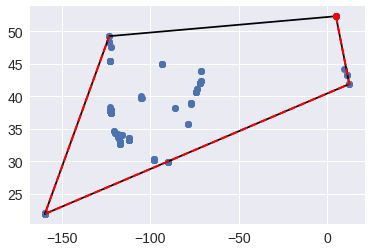

Volume is 2674.27
Area is 359.56
ericjamesu


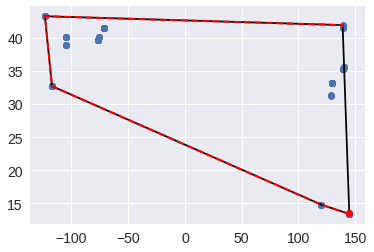

Volume is 5105.44
Area is 566.17
jsonin


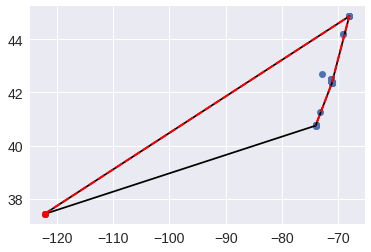

Volume is 90.58
Area is 110.32
Leaventhall


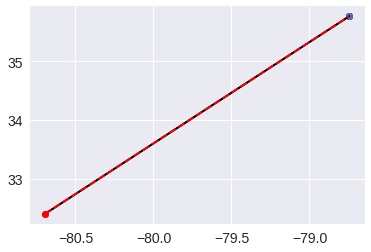

Volume is 0.00
Area is 7.79
wramey82


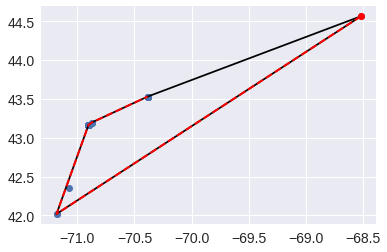

Volume is 1.25
Area is 7.63
your own data


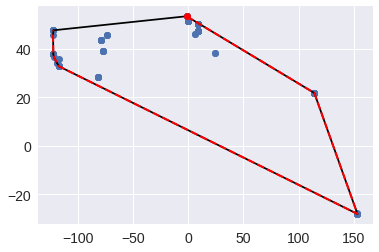

Volume is 9518.02
Area is 598.95


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os
#from RDP import rdp #import rdp
import networkx as nx
from scipy.spatial import ConvexHull


N = 10 # number of points  
M = 5 # dimensions

"""
LOADING input data:
# entries:  public_i pub_tag_i pub_time_i  
# public#i (Name and title encoded into number -> separate table) 
# tag of publication: there are finite number of tags (some of them are not corresponding to one field)
# time index is better to make in linear scale -> 1:365*y, where y is number of years)
"""

#data points should be data from trajectories of researchers
data = np.random.rand(N,M) #generate N datapoints in M dimensions
#data = np.random.rand(30, 2)   # 30 random points in 2-D

#load trajectory from Openhumans file

#print(data)
                       
"""
function ALGORITHM convext hull
"""
         

def convex_hull(data):
              
    hull = ConvexHull(data)

    plt.plot(data[:,1], data[:,0], 'o')
    for simplex in hull.simplices:
        plt.plot(data[simplex, 1], data[simplex, 0], 'k-')
    
    
    plt.plot(data[hull.vertices,1], data[hull.vertices,0], 'r--', lw=2)
    plt.plot(data[hull.vertices[0],1], data[hull.vertices[0],0], 'ro')
    plt.show()   


    """
    estimate the volume of the convex hull for trajectory in time frame
    """ 


    #points = np.array([[-1,-1, 1], [1, 1, 0], [-1, 1, 0], [1,-1, -1]])
    #hull = ConvexHull(points)
    print("Volume is %2.2f" % hull.volume) # N-d object
    print("Area is %2.2f" % hull.area) # (N-1)-d object

    
'''
Now we apply convex hull to different data
'''
for k,v in latlongs.items():
    print(k)
    convex_hull(np.asarray(v))

# check whether member has personal data as well

if my_data: 
    
    print('your own data')
    convex_hull(np.asarray(my_latlon))
    

### Convex hull sliding window analysis of trajectories
We also analyze trajectory using sliding window analysis, where we measure the volume of convex hull V(t,t+delta t) for trajectory X(t) during the period of (delat t). 
To read more about convex hull algorithm applied to particle trajectories 
https://arxiv.org/pdf/1708.06517.pdf

In [ ]:


import matplotlib.pyplot as plt
import numpy as np
import os
#from RDP import rdp #import rdp
import networkx as nx
from scipy.spatial import ConvexHull


N = 10 # number of points  
M = 5 # dimensions

"""
LOADING input data:
# entries:  public_i pub_tag_i pub_time_i  
# public#i (Name and title encoded into number -> separate table) 
# tag of publication: there are finite number of tags (some of them are not corresponding to one field)
# time index is better to make in linear scale -> 1:365*y, where y is number of years)
"""

#data points should be data from trajectories of researchers
data = np.random.rand(N,M) #generate N datapoints in M dimensions
#data = np.random.rand(30, 2)   # 30 random points in 2-D

#load trajectory from Openhumans file
data1 = np.asarray(latlon1) #give array, not the list
data2 = np.asarray(latlon2) #get data from the second participant

#print(data)
                       
"""
function ALGORITHM convext hull
"""
         

def convex_hull_sliding_window(data, steps, size_window):
    '''
    data - trajectory
    steps - number of time steps in trajectory 
    size_window - time size of the sliding window
    '''

    volume_array = np.zeros(steps)
    
    for itime in range(0, steps):
        time_max = (itime +size_window)%(steps+1) #calculate maximum time for sliding window
        data_i = data[itime: time_bound] #cut data_i  from origianal data by cutting trajectory 
        convex_hull(data_i) #apply convex_hull function
    
    return volume_array